In [ ]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

import matplotlib
%matplotlib inline

from matplotlib import pyplot as plt

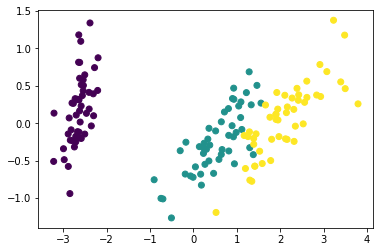

In [ ]:
iris= load_iris()
iris_d = iris['data']
iris_l = iris['target']
iris_pca = PCA(n_components=2).fit_transform(iris_d)
plt.scatter(iris_pca[:,0], iris_pca[:,1],c=iris_l)

## Elbow Method

Método del codo: Vamos a medir la distancia mínima entre los elementos del arreglo y los centroides. Nos quedaremos con el primer valor de k que cuyo valor ya no descienda drásticamente y se empiece a notar que se estabiliza.

In [ ]:
from scipy.spatial.distance import cdist
distancias = lambda centroides, X: sum(np.min(cdist(X, centroides, 'euclidean'), axis=1)) / X.shape[0]

x1 = np.array([3, 1, 1, 2, 1, 6, 6, 6, 5, 6, 7, 8, 9, 8, 9, 9, 8])
x2 = np.array([5, 4, 5, 6, 5, 8, 6, 7, 6, 7, 1, 2, 1, 2, 3, 2, 3])
X  = np.array(list(zip(x1, x2))).reshape(len(x1), 2)
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append( distancias(kmeanModel.cluster_centers_, X))


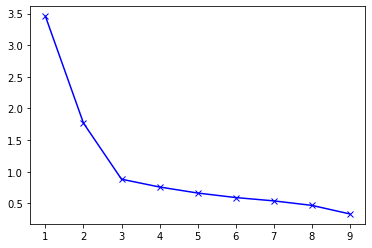

In [ ]:
plt.plot(K, distortions, 'bx-')

Aquí se ve que la mejor cantidad de grupos para los puntos en X para los siguientes puntos


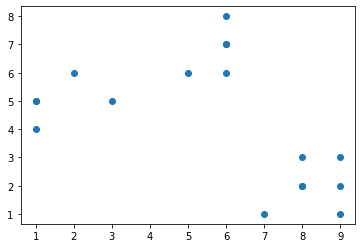

In [ ]:
plt.scatter(x1,x2)

## Daves-Bouldin index

En la definición de `sklearn` se describe este índice como:

> The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score.

Es decir, como dice la última frase, va a calificar mejor a los grupos que están más lejanos posibles así como menos dispersos.

Funciona así, requerimos construir una medida general de separación de grupos (_clusters_) $R(S_i, S_j, M_{ij})$ que permita el cómputo de similitud promedio dentre cada grupo y el más parecido a él.

Definimos a $R$ son como sigue:

$$R_{ij} \equiv \frac {S_i + S_j}{M_{ij}}$$ 

Y a $\bar R$ como:

$$R_i \equiv \frac {1}{N} \sum_{i=1}^{N} {R_i}$$ 

donde $R_i = \max R_{ij} ; i \neq j$

**La mejor elección de grupos será aquella que minimice a $\bar R$**. $S_i$ es una medida de dispersión dentro de los grupos y $M_{ij}$ es la dispersión entre centroides. Ambas se definen a continuación:

$$
S_i = \left \lbrace \frac {1}{T_i} \sum_{j=1}^{T_i} | X_j - A_i|^q \right \rbrace ^{1/q}
$$

donde $A_i$ es el centroide i-ésimo y $T_i$ es la cantidad de puntos en grupo $i$. $M_{ij}$ no es otra cosa que la métrica de Minkowski

$$
M_{ij} = \left \lbrace \sum_{k=1}^{N} | a_{ki} - a_{kj}|^p \right \rbrace ^{1/p}
$$

Para más información leer: Davies, David L.; Bouldin, Donald W. (1979). “A Cluster Separation Measure”. IEEE Transactions on Pattern Analysis and Machine Intelligence. PAMI-1 (2): 224-227

Si lo aplicamos al ejemplo anterior usando la [implementacion de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html), obtenemos lo siguiente:

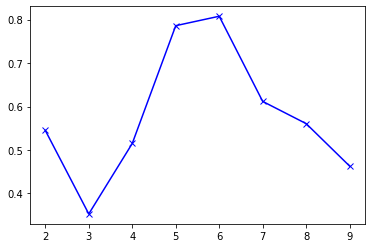

In [ ]:
db_indices = []
K = range(2,10)  #el número de clases debe empezar en 2
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    etiqs      = kmeanModel.labels_

    db_indices.append( davies_bouldin_score(X, etiqs))
plt.plot(K, db_indices, 'bx-')

Como podemos ver, el índice se minimiza en 3, por lo tanto esa será la cantidad de grupos que elegiremos.

## Kmeans en Iris

¿Cuántos grupos hay en iris?

Vamos a probar varios claisifcadores (variamos la cantidad de grupos) en Iris y eligiremos la cantidad de grupos usando dos métricas.

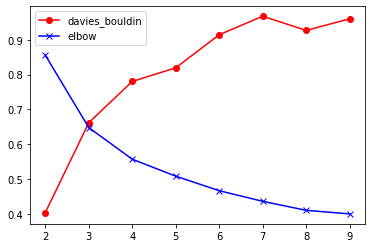

In [ ]:
K = range(2,10)
elbow_iris, db_iris = [], []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1).fit(iris_d)
    etiqs  = kmeans.labels_
    elbow_iris.append( distancias(kmeans.cluster_centers_, iris_d))
    db_iris.append(davies_bouldin_score(iris_d, etiqs))
plt.plot(K, db_iris, 'ro-', label='davies_bouldin')
plt.plot(K, elbow_iris, 'bx-', label='elbow')
plt.legend()

De acuerdo a este par de métricas la cantidad de grupos en iris debería ser 2, de acuerdo a davies-bouldin. Y con el método del codo es difícil decidir a simple vista.

## DBSCAN

Para probar a `DBSCAN` primero tenemos que generar un par de puntos que no sean linealmente separables. Eso lo podemos lograr con los métodos para generar puntos de `sklearn`

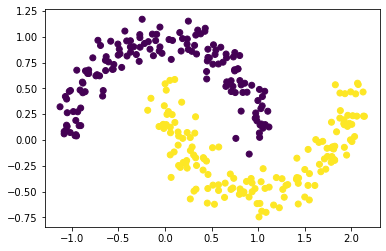

In [ ]:
from sklearn.datasets import make_moons

datos, y = make_moons(n_samples=300, noise=0.1)

plt.scatter(datos[:,0], datos[:,1], c=y )

Le vamos a indicar a `DBSCAN` que tome 20 puntos para que un _cluster_ se considere como tal y `eps=0.3` será la distancia para que un punto sea considerado dentro de un grupo.

[ 0  1  1  1  1  0  0 -1  1  1  1  0  0  0  0  0  1  0  1  0  0  1  0  0
  1  0  1  0  0  1  1  1  1  0  0  0  1  1  1  1  1  0  0  0  1  1  0  0
  0  1  0  1  0  0  0  1  1  0  1  1  1  0  0  0  0  0  0  1  0  1  0  1
  1  1  1  0  0  0  0  1  0  1  0  0  1  1  1  1  1  0  1  1  0  1  0  1
  1  1  1  0  0  0  1  0  1  1  0  1  1  0  1  0  0  1  0  1  1  1  0  1
  0  1  1  0  1  0  1  0  0  1  0  0  0  0  0  1  0  1  1  1  1  0  1  1
  0  1  1  0  0  0  1  0  1  1  0  1  0  0  0  1  1  1  1  0  0  0  0  1
  0  1  1  1  0  1  1  1  0  1  1  0  1  0  0  0  0  0  1  0  0  0  0  1
  0  1  0  0  0  1  1  1  0  0  1  1  0  1  0  1  0  0  1  0  0  1  1  1
  0  0  1  0  0  1  0  0  0  1  0  0  0  0  1  1  0 -1  0  1  1  0  1  1
  1  0  1  1  0  0  1  0  1  0  1  0  0  1  1  0  1  0  0  1  0  1  1  1
  1  1  0  0  1  0  0  1  1  0  0  1  0  0  0  0  1  1  0  1  1  0  1  0
  0  1  1  0  0  1  1  0  1  0  1  0]


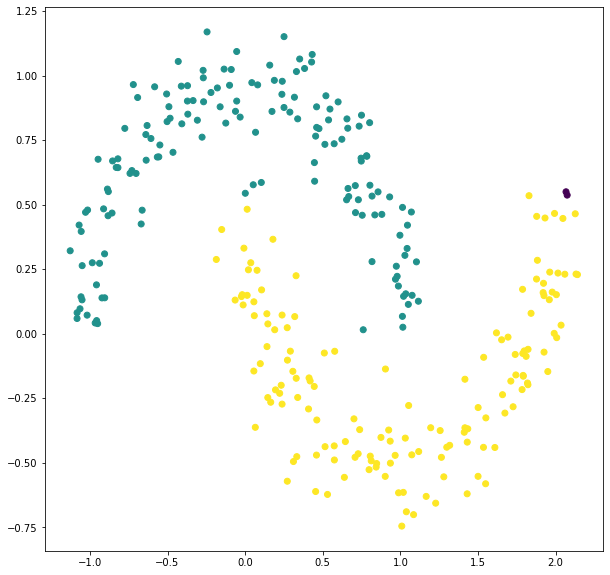

In [ ]:
db = DBSCAN(eps=0.3, min_samples=20)
db.fit(datos)
labs = db.labels_
print(labs)
f, ax = plt.subplots(1,1)
f.set_size_inches((10,10))
ax.scatter(datos[:,0], datos[:,1], c=labs)

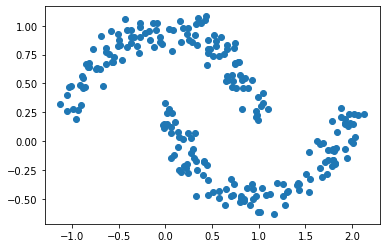

In [ ]:
plt.scatter(db.components_[:,0], db.components_[:,1])